# Import

In [1]:
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
from keras.models import Model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout, Input, AveragePooling2D, Lambda
from urllib import request
from keras.callbacks import TensorBoard
import tempfile
from keras import optimizers
from keras.utils import Sequence
import numpy as np
from tqdm import tqdm
from datetime import datetime
from keras.applications import vgg16, resnet50
from glob import glob
from IPython.display import Image


/home/trule/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Define parameters

In [2]:
ROOT_DIR = '../input/dog-breed'
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DIR, 'test')

EPOCHS = 50
BATCH_SIZE = 512
IMAGE_SIZE = (224,224)
INPUT_SHAPE = IMAGE_SIZE + (3,)

# Fetch data (if not exist)

In [3]:
def fetch_data():
    if not os.path.exists(ROOT_DIR):
        os.makedirs(ROOT_DIR)
        zip_path = os.path.join(tempfile.gettempdir(), 'dog-breed.zip')
        print('Start download!')
        request.urlretrieve('https://kienle.blob.core.windows.net/public/kaggle/dog-breed.zip', zip_path)
        print('Start unzip')
        import zipfile
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(ROOT_DIR)
        with zipfile.ZipFile(os.path.join(ROOT_DIR,'test.zip'), 'r') as zip_ref:
            zip_ref.extractall(ROOT_DIR)
        with zipfile.ZipFile(os.path.join(ROOT_DIR,'train.zip'), 'r') as zip_ref:
            zip_ref.extractall(ROOT_DIR)
        os.remove(zip_path)
        os.remove(os.path.join(ROOT_DIR,'train.zip'))
        os.remove(os.path.join(ROOT_DIR,'test.zip'))
        print('Done')
fetch_data()

In [4]:
# Confirm all data are ready 
# Expected output: labels.csv  sample_submission.csv  test  train
!ls $ROOT_DIR

labels.csv  sample_submission.csv  test  train


# Explore dataset

In [5]:
pd_images = pd.read_csv(os.path.join(ROOT_DIR, 'labels.csv'))

In [6]:
pd_images.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


boston_bull


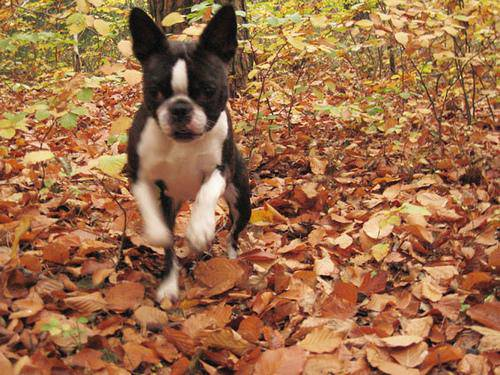

In [7]:
title = pd_images.breed[0]
path = os.path.join(TRAIN_DIR, pd_images.id[0] + '.jpg')
print(title)
Image(filename=path)

# Load images by ImageDataGenerator

In [8]:
image_gen = ImageDataGenerator()

In [9]:
train_valid_generator = image_gen.flow_from_dataframe(pd_images, TRAIN_DIR, batch_size=BATCH_SIZE, x_col='id', y_col='breed', has_ext=False, target_size=IMAGE_SIZE)

Found 10222 images belonging to 120 classes.


In [10]:
num_classes = len(train_valid_generator.class_indices)

# Feature extractions using pretrained models

In [11]:
class FeaturesExtractor():
    def __init__(self, input_shape, pretrained_model, preprocess_input):
        self.input_shape = input_shape
        model = pretrained_model(include_top=False, input_shape=self.input_shape, weights='imagenet')
        inputs = Input(self.input_shape)
        x = inputs
        x = Lambda(preprocess_input, name='preprocessing')(x)
        x = model(x)
        x = GlobalAveragePooling2D()(x)
        model = Model(inputs, x)
        self.model = model
    def predict(self, X):
        return self.model.predict(X)
    def predict_generator(self, X):
        return self.model.predict_generator(X)

# Prepare training dataset

In [12]:
X_train = np.zeros((train_valid_generator.n,) + INPUT_SHAPE)
y_train = np.zeros((train_valid_generator.n, 120))
for i in tqdm(range(len(train_valid_generator)), ncols=100):
    temp_x, temp_y = train_valid_generator[i]
    start_index = i*train_valid_generator.batch_size
    X_train[start_index:start_index + temp_x.shape[0]] = temp_x
    y_train[start_index:start_index + temp_x.shape[0]] = temp_y


100%|███████████████████████████████████████████████████████████████| 20/20 [00:33<00:00,  1.67s/it]


# Model creation function

In [13]:
def create_simple_model(num_classes, input_shape):
    inputs = Input(input_shape)
    x = inputs
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, x)

# Use vgg16

In [14]:
vgg_features_extractor = FeaturesExtractor(INPUT_SHAPE, vgg16.VGG16, vgg16.preprocess_input)

In [15]:
# Calculate vgg features
vgg_features = vgg_features_extractor.predict(X_train)

In [16]:
vgg_based_model = create_simple_model(num_classes, vgg_features_extractor.model.output.get_shape().as_list()[1:])
vgg_based_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [TensorBoard('./data/logs/vgg-{0}'.format(datetime.now().isoformat().replace(':','-').split('.')[0]))]
    
vgg_based_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560     
Total params: 61,560
Trainable params: 61,560
Non-trainable params: 0
_________________________________________________________________


In [17]:
vgg_based_model.fit(vgg_features, y_train, batch_size=256, epochs=EPOCHS, callbacks=callbacks, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/50
9199/9199 [==============================] - 0s 45us/step - loss: 14.8333 - acc: 0.0185 - val_loss: 12.6793 - val_acc: 0.0704
Epoch 2/50
9199/9199 [==============================] - 0s 9us/step - loss: 13.6406 - acc: 0.0547 - val_loss: 10.7079 - val_acc: 0.1486
Epoch 3/50
9199/9199 [==============================] - 0s 10us/step - loss: 12.4091 - acc: 0.0960 - val_loss: 9.1811 - val_acc: 0.2375
Epoch 4/50
9199/9199 [==============================] - 0s 9us/step - loss: 11.1361 - acc: 0.1498 - val_loss: 8.0194 - val_acc: 0.3118
Epoch 5/50
9199/9199 [==============================] - 0s 10us/step - loss: 10.1549 - acc: 0.1950 - val_loss: 7.2459 - val_acc: 0.3441
Epoch 6/50
9199/9199 [==============================] - 0s 9us/step - loss: 9.1398 - acc: 0.2488 - val_loss: 6.3833 - val_acc: 0.4037
Epoch 7/50
9199/9199 [==============================] - 0s 9us/step - loss: 8.3620 - acc: 0.2827 - val_loss: 5.6026 - val_acc: 0.4370
Epoc

# Use resnet50

In [18]:
resnet50_features_extractor = FeaturesExtractor(INPUT_SHAPE, resnet50.ResNet50, resnet50.preprocess_input)

/home/trule/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [19]:
resnet50_features = resnet50_features_extractor.predict(X_train)

In [20]:
resnet50_based_model = create_simple_model(num_classes, resnet50_features_extractor.model.output.get_shape().as_list()[1:])
resnet50_based_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [TensorBoard('./data/logs/resnet50-{0}'.format(datetime.now().isoformat().replace(':','-').split('.')[0]))]

In [21]:
resnet50_based_model.fit(resnet50_features, y_train, batch_size=256, epochs=EPOCHS,  callbacks=callbacks, validation_split=0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/50
9199/9199 [==============================] - 0s 41us/step - loss: 3.8610 - acc: 0.1826 - val_loss: 1.8604 - val_acc: 0.5523
Epoch 2/50
9199/9199 [==============================] - 0s 13us/step - loss: 1.6788 - acc: 0.5436 - val_loss: 1.2054 - val_acc: 0.6833
Epoch 3/50
9199/9199 [==============================] - 0s 13us/step - loss: 1.1664 - acc: 0.6689 - val_loss: 1.0194 - val_acc: 0.7195
Epoch 4/50
9199/9199 [==============================] - 0s 13us/step - loss: 0.9302 - acc: 0.7283 - val_loss: 0.9346 - val_acc: 0.7419
Epoch 5/50
9199/9199 [==============================] - 0s 13us/step - loss: 0.7767 - acc: 0.7724 - val_loss: 0.9016 - val_acc: 0.7468
Epoch 6/50
9199/9199 [==============================] - 0s 13us/step - loss: 0.6706 - acc: 0.8002 - val_loss: 0.8732 - val_acc: 0.7439
Epoch 7/50
9199/9199 [==============================] - 0s 13us/step - loss: 0.5911 - acc: 0.8243 - val_loss: 0.8257 - val_acc: 0.7605
Epoch 8

# Confusion matrix (VGG)

In [22]:
index2labels = {}
for k, v in train_valid_generator.class_indices.items():
    index2labels[v] = k

In [23]:
preds = []
targets = []
for i in tqdm(range(len(train_valid_generator)), ncols=100):
    x, y = train_valid_generator[i]
    p = vgg_based_model.predict(vgg_features_extractor.predict(x))
    p = np.argmax(p, axis=1)    
    y = np.argmax(y, axis=1)
    preds = np.concatenate((preds, p))
    targets = np.concatenate((targets, y))
from sklearn.metrics import confusion_matrix
print(np.sum(targets == preds))
print(preds[0:10])
print(targets[0:10])
cm = confusion_matrix(targets, preds)
print(cm[0:10, 0:10])

100%|███████████████████████████████████████████████████████████████| 20/20 [01:03<00:00,  3.13s/it]

8621
[ 67.  63.  23.  48.  36. 113. 117.  26.  99. 110.]
[ 67.  63.  23.  48.  36. 113. 117.  26. 109. 110.]
[[ 84   0   0   0   0   0   0   0   0   0]
 [  0  72   0   0   0   0   0   2   0   0]
 [  0   0  66   0   0   0   0   0   0   0]
 [  0   0   0  82   0   0   0   0   0   0]
 [  0   0   0   0  62   0   0   0   0   0]
 [  0   0   0   0   0  87   0   0   0   0]
 [  0   0   0   0   0   0  70   0   0   0]
 [  0   0   0   0   0   0   0 108   0   0]
 [  0   0   0   0   0   0   0   0 114   0]
 [  0   0   0   0   0   0   0   0   0  75]]


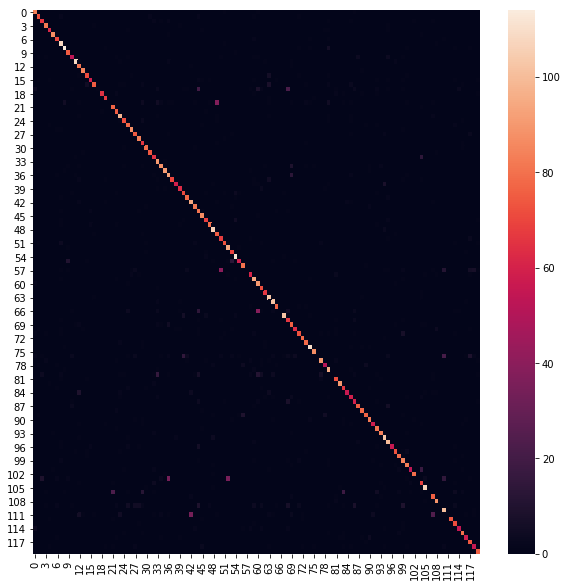

In [24]:
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,10))
sn.heatmap(df_cm, annot=False)

# Prediction